In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

print(os.listdir("dataset"))

['HAM10000_metadata.csv', 'HAM10000_images_part_1', 'hmnist_8_8_L.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_2', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_L.csv']


In [2]:
data_dir = 'dataset'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [4]:
norm_mean, norm_std = compute_img_mean_std(all_image_path)

100%|████████████████████████████████████████████████████████████████████████████| 10015/10015 [01:18<00:00, 126.84it/s]


(224, 224, 3, 10015)
normMean = [0.76303905, 0.54564434, 0.5700453]
normStd = [0.14092831, 0.15261248, 0.16997118]


In [5]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,dataset/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [6]:
# Count the number of females and males in the dataset
gender_counts = df_original['sex'].value_counts()
print(gender_counts)


male       5406
female     4552
unknown      57
Name: sex, dtype: int64


In [7]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [8]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,dataset/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,dataset/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [9]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [10]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [11]:
y = df_undup['cell_type_idx']
df_train, df_val = train_test_split(df_undup, test_size=0.5, random_state=101, stratify=y)
df_train.shape, df_val.shape

((2757, 11), (2757, 11))

In [12]:
# Calculate the number of males and females in the train dataset
train_male_count = len(df_train[df_train['sex'] == 'male'])
train_female_count = len(df_train[df_train['sex'] == 'female'])

# Calculate the number of males and females in the validation dataset
val_male_count = len(df_val[df_val['sex'] == 'male'])
val_female_count = len(df_val[df_val['sex'] == 'female'])

print("Training dataset:")
print(f"Males: {train_male_count}")
print(f"Females: {train_female_count}")

print("\nValidation dataset:")
print(f"Males: {val_male_count}")
print(f"Females: {val_female_count}")


Training dataset:
Males: 1435
Females: 1300

Validation dataset:
Males: 1472
Females: 1262


In [13]:
df_val['cell_type_idx'].value_counts()

4    2208
2     220
6     115
1      88
0      75
5      32
3      19
Name: cell_type_idx, dtype: int64

In [14]:
df_train['cell_type_idx'].value_counts()

4    2207
2     220
6     115
1      87
0      76
5      32
3      20
Name: cell_type_idx, dtype: int64

In [15]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(f"Training dataset: {len(df_train)}")
print(f"Validation dataset: { len(df_val)}")

Training dataset: 7258
Validation dataset: 2757


In [16]:
# Calculate the number of males and females in the train dataset
train_male_count = len(df_train[df_train['sex'] == 'male'])
train_female_count = len(df_train[df_train['sex'] == 'female'])

# Calculate the number of males and females in the validation dataset
val_male_count = len(df_val[df_val['sex'] == 'male'])
val_female_count = len(df_val[df_val['sex'] == 'female'])

print("Training dataset:")
print(f"Males: {train_male_count}")
print(f"Females: {train_female_count}")

print("\nValidation dataset:")
print(f"Males: {val_male_count}")
print(f"Females: {val_female_count}")


Training dataset:
Males: 3934
Females: 3290

Validation dataset:
Males: 1472
Females: 1262


In [17]:
df_train['cell_type_idx'].value_counts()

4    4497
6     998
2     879
1     426
0     252
5     110
3      96
Name: cell_type_idx, dtype: int64

In [18]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  2208
Benign keratosis-like lesions      220
dermatofibroma                     115
Basal cell carcinoma                88
Actinic keratoses                   75
Vascular lesions                    32
Dermatofibroma                      19
Name: cell_type, dtype: int64

In [19]:
df_train['sex'].value_counts()

male       3934
female     3290
unknown      34
Name: sex, dtype: int64

In [20]:
df_train['age'].value_counts()

45.0    835
50.0    786
55.0    686
40.0    666
70.0    605
60.0    572
65.0    567
35.0    539
75.0    477
30.0    363
80.0    312
85.0    254
25.0    194
20.0    146
15.0     74
5.0      74
0.0      38
10.0     37
Name: age, dtype: int64

In [21]:
df_train['localization'].value_counts()

back               1691
lower extremity    1461
upper extremity     879
trunk               803
abdomen             674
face                630
chest               350
foot                240
unknown             141
neck                132
scalp               109
hand                 66
ear                  48
genital              28
acral                 6
Name: localization, dtype: int64

## Bias Mitigation: Data Augmentation (Oversampling training data)

In [22]:
# # Copy fewer class to balance the number of 7 classes
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

/tmp/ipykernel_661580/2085359477.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)


dermatofibroma                    4990
Dermatofibroma                    4800
Melanocytic nevi                  4497
Vascular lesions                  4400
Benign keratosis-like lesions     4395
Basal cell carcinoma              4260
Actinic keratoses                 3780
Name: cell_type, dtype: int64

In [27]:
# split validation into val and test
df_val, df_test = train_test_split(df_val, test_size=0.7)  
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()


In [28]:
print(f" Training dataset size: {len(df_train)}")
print(f" Testing dataset size: {len(df_test)}")
print(f" Validation dataset size: {len(df_val)}")

 Training dataset size: 31122
 Testing dataset size: 579
 Validation dataset size: 248


In [29]:
df_train['age'].value_counts()

70.0    3568
65.0    3331
75.0    3187
55.0    3057
50.0    2904
60.0    2771
45.0    2500
80.0    2294
85.0    1756
40.0    1724
35.0    1428
30.0     899
25.0     574
20.0     318
15.0     230
0.0      210
5.0      191
10.0     115
Name: age, dtype: int64

In [30]:
# Filter the test dataset based on age groups
below_20_df = df_test[df_test['age'] <= 20].reset_index(drop=True)
between_20_40_df = df_test[(df_test['age'] > 20) & (df_test['age'] <= 40)].reset_index(drop=True)
between_40_60_df = df_test[(df_test['age'] > 40) & (df_test['age'] <= 60)].reset_index(drop=True)
above_60_df = df_test[df_test['age'] > 60].reset_index(drop=True)


In [31]:
# Assuming your DataFrame is called 'df' and has a column 'age' with the age of each sample
age_bins = [0, 20, 40, 60, np.inf]
age_group_labels = [0, 1, 2, 3]
df_train['age_group'] = pd.cut(df_train['age'], bins=age_bins, labels=age_group_labels)
df_val['age_group'] = pd.cut(df_train['age'], bins=age_bins, labels=age_group_labels)
df_test['age_group'] = pd.cut(df_train['age'], bins=age_bins, labels=age_group_labels)

df_train = df_train.dropna(subset=['age_group'])
df_val = df_val.dropna(subset=['age_group'])
df_test = df_test.dropna(subset=['age_group'])

df_train = df_train.dropna(subset=['age_group']).reset_index(drop=True)
df_val = df_val.dropna(subset=['age_group']).reset_index(drop=True)
df_test = df_test.dropna(subset=['age_group']).reset_index(drop=True)




In [32]:
print(f" Training dataset size: {len(df_train)}")
print(f" Testing dataset size: {len(df_test)}")
print(f" Validation dataset size: {len(df_val)}")

 Training dataset size: 30847
 Testing dataset size: 577
 Validation dataset size: 246


In [33]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [34]:
# let's define the GradientReversalLayer and AgeClassifier classes:
import torch.nn.functional as F

class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -grad_output

class AgeClassifier(nn.Module):
    def __init__(self, num_classes, num_age_groups):
        super(AgeClassifier, self).__init__()
        self.fc = nn.Linear(num_classes, num_age_groups)

    def forward(self, x):
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    

# import torch.nn.functional as F

# class GradientReversalLayer(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, x):
#         return x.view_as(x)

#     @staticmethod
#     def backward(ctx, grad_output):
#         return -grad_output

# class AgeClassifier(nn.Module):
#     def __init__(self, num_classes, num_age_groups, hidden_size):
#         super(AgeClassifier, self).__init__()
#         self.fc1 = nn.Linear(num_classes, hidden_size) # Add a hidden layer
#         self.relu = nn.ReLU() # Add a ReLU activation function
#         self.fc2 = nn.Linear(hidden_size, num_age_groups) # Add another linear layer

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)



In [35]:
#  let's modify the initialize_model function to add the age classifier:


from torchvision.models import resnet18, vgg16, densenet121, inception_v3, resnet50, resnet101
from torchvision.models.densenet import DenseNet121_Weights

#def initialize_model(model_name, num_classes, num_age_groups, hidden_size, feature_extract, use_pretrained=True):

def initialize_model(model_name, num_classes, num_age_groups, feature_extract, use_pretrained=True):

    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    # modified only this
    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1 if use_pretrained else None)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

        #age_classifier = AgeClassifier(num_classes, num_age_groups, hidden_size)
        age_classifier = AgeClassifier(num_classes, num_age_groups)

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, age_classifier, input_size



In [36]:
# resnet,vgg,densenet,inception

# Define the device:
device = torch.device('cuda:4')


model_name = 'densenet'
num_classes = 7

feature_extract = False


# Define hidden_size
#hidden_size = 128



num_age_groups = 4  # Define the number of age groups

# Add hidden_size to initialize_model function call
#model_ft, age_classifier, input_size = initialize_model(model_name, num_classes, num_age_groups, hidden_size, feature_extract, use_pretrained=True)


model_ft, age_classifier, input_size = initialize_model(model_name, num_classes, num_age_groups, feature_extract, use_pretrained=True)

age_classifier = age_classifier.to(device)




# Put the model on the device:
model = model_ft.to(device)




In [37]:
train_transform = transforms.Compose([transforms.Resize((224, 224)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# define the transformation of the val images.
test_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [38]:
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))
        age_group = torch.tensor(int(self.df['age_group'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y, age_group


In [39]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)


# transform for the validation set
validation_set = HAM10000(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)
# transform for the test  set (No jitter, rotations)
test_set = HAM10000(df_test, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

## Adversarial Training

In [40]:
# for classifier training
optimizer_age = optim.SGD(age_classifier.parameters(), lr=0.001, momentum=0.9)
#criterion_age = nn.NLLLoss()
criterion_age = nn.CrossEntropyLoss().to(device)




# model training
# we use Adam optimizer, use weighted-cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)



In [41]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [42]:
def train(train_loader, model, age_classifier, criterion, criterion_age, optimizer, optimizer_age, epoch):
    model.train()
    age_classifier.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    age_loss_meter = AverageMeter()
    age_acc = AverageMeter()

    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels, age_groups = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        age_groups = Variable(age_groups).to(device)

        optimizer.zero_grad()
        optimizer_age.zero_grad()

        # Compute the model output and the age classifier output
        outputs = model(images)
        age_outputs = age_classifier(GradientReversalLayer.apply(outputs))

        # Compute the classification loss and the adversarial loss
        loss = criterion(outputs, labels)
        age_loss = criterion_age(age_outputs, age_groups)
        total_loss = loss + 0.05 * age_loss   # alpha (adversarial loss)

        total_loss.backward()
        optimizer.step()
        optimizer_age.step()

        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        
        age_prediction = age_outputs.max(1, keepdim=True)[1]
        age_acc_value = age_prediction.eq(age_groups.view_as(age_prediction)).sum().item()/N
        age_acc.update(age_acc_value)
        age_loss_meter.update(age_loss.item())

        curr_iter += 1
    
    print('[epoch %d], [train loss %.5f], [train acc %.5f], [age loss %.5f], [age acc %.5f]' % (
        epoch, train_loss.avg, train_acc.avg, age_loss_meter.avg, age_acc.avg))
    total_loss_train.append(train_loss.avg)
    total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg, age_loss_meter.avg, age_acc.avg





In [43]:
def validate(val_loader, model, age_classifier, criterion, criterion_age, optimizer, optimizer_age, epoch):
    model.eval()
    age_classifier.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    age_loss_meter = AverageMeter()
    age_acc = AverageMeter()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels, age_groups = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            age_groups = Variable(age_groups).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]
            age_outputs = age_classifier(GradientReversalLayer.apply(outputs))
            age_prediction = age_outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
            val_loss.update(criterion(outputs, labels).item())
            age_loss_meter.update(criterion_age(age_outputs, age_groups).item())
            age_acc.update(age_prediction.eq(age_groups.view_as(age_prediction)).sum().item()/N)

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f], [age val loss %.5f], [age val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg, age_loss_meter.avg, age_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg, age_loss_meter.avg, age_acc.avg


In [69]:
epoch_num = 25
best_val_acc = 0

total_loss_train, total_acc_train, total_age_loss_train, total_age_acc_train = [], [], [], []
total_loss_val, total_acc_val , total_age_loss_val, total_age_acc_val= [], [], [],[]

for epoch in range(1, epoch_num+1):
    # Train the model and the age classifier
    loss_train, acc_train, age_loss_train, age_acc_train = train(train_loader, model, age_classifier, criterion, criterion_age, optimizer, optimizer_age, epoch)
    
    # Validate the model and the age classifier
    loss_val, acc_val, loss_val_age, acc_val_age = validate(val_loader, model, age_classifier, criterion, criterion_age, optimizer, optimizer_age, epoch)
    
    total_loss_train.append(loss_train)
    total_acc_train.append(acc_train)
    total_age_loss_train.append(age_loss_train)
    total_age_acc_train.append(age_acc_train)
    
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    
        
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model.state_dict(), "adversarial_learning_skin_lesion.pt")
        torch.save(age_classifier.state_dict(), "age_classifier_skin_lesion.pt")
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')
    


[epoch 1], [train loss 0.88438], [train acc 0.66872], [age loss 1.64797], [age acc 0.32308]
------------------------------------------------------------
[epoch 1], [val loss 0.53104], [val acc 0.81533], [age val loss 1.31907], [age val acc 0.31674]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.53104], [val acc 0.81533]
*****************************************************
[epoch 2], [train loss 0.58551], [train acc 0.77816], [age loss 1.28586], [age acc 0.43463]
------------------------------------------------------------
[epoch 2], [val loss 0.41310], [val acc 0.87302], [age val loss 1.41809], [age val acc 0.29270]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.41310], [val acc 0.87302]
*****************************************************
[epoch 3], [train loss 0.47054], [train 

[epoch 25], [train loss 0.06764], [train acc 0.97394], [age loss 1.10239], [age acc 0.46235]
------------------------------------------------------------
[epoch 25], [val loss 0.56028], [val acc 0.88504], [age val loss 1.00528], [age val acc 0.57756]
------------------------------------------------------------


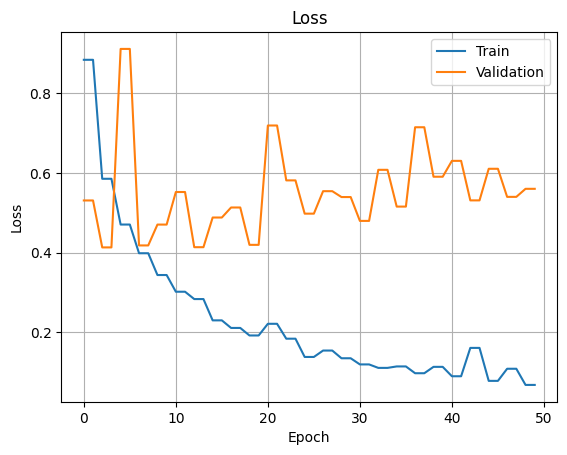

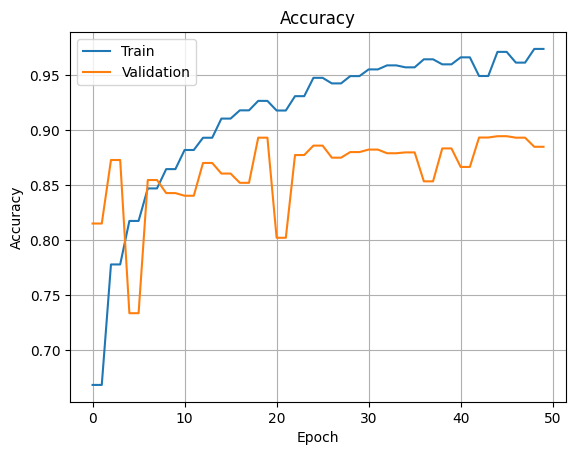

In [70]:


plt.plot(total_loss_train, label='Train')
plt.plot(total_loss_val, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the training and validation accuracy
plt.plot(total_acc_train, label='Train')
plt.plot(total_acc_val, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()



In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

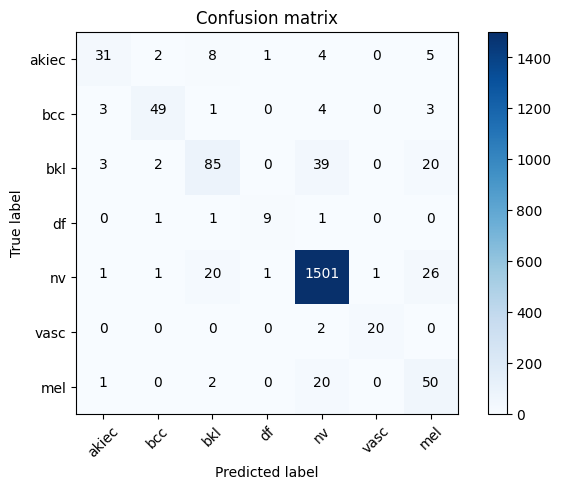

In [76]:
# Load saved state dict of trained model



state_dict = torch.load('adversarial_learning_skin_lesion.pt')
model.load_state_dict(state_dict)


model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels, _ = data  # add "_" to unpack the age_groups
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [77]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.79      0.61      0.69        51
         bcc       0.89      0.82      0.85        60
         bkl       0.73      0.57      0.64       149
          df       0.82      0.75      0.78        12
          nv       0.96      0.97      0.96      1551
        vasc       0.95      0.91      0.93        22
         mel       0.48      0.68      0.56        73

    accuracy                           0.91      1918
   macro avg       0.80      0.76      0.77      1918
weighted avg       0.91      0.91      0.91      1918



## Bias Investigation

### 2. Gender

In [79]:
df_test.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates,age_group
0,1047,HAM_0000453,ISIC_0025330,bkl,consensus,50.0,female,lower extremity,dataset/HAM10000_images_part_1/ISIC_0025330.jpg,Benign keratosis-like lesions,2,unduplicated,3
1,2211,HAM_0006955,ISIC_0025105,mel,histo,65.0,male,back,dataset/HAM10000_images_part_1/ISIC_0025105.jpg,dermatofibroma,6,unduplicated,3
2,6590,HAM_0006073,ISIC_0025761,nv,follow_up,65.0,female,lower extremity,dataset/HAM10000_images_part_1/ISIC_0025761.jpg,Melanocytic nevi,4,unduplicated,3
3,6588,HAM_0002249,ISIC_0029520,nv,follow_up,65.0,female,trunk,dataset/HAM10000_images_part_2/ISIC_0029520.jpg,Melanocytic nevi,4,unduplicated,3
4,5296,HAM_0004353,ISIC_0029262,nv,follow_up,55.0,female,face,dataset/HAM10000_images_part_1/ISIC_0029262.jpg,Melanocytic nevi,4,unduplicated,3


In [80]:

male_df_test = df_test[df_test['sex'] == 'male']
female_df_test = df_test[df_test['sex'] == 'female']
        

In [81]:
female_df_test = female_df_test.reset_index()
female_df_test.head()

,level_0,index,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates,age_group
0,0,1047,HAM_0000453,ISIC_0025330,bkl,consensus,50.0,female,lower extremity,dataset/HAM10000_images_part_1/ISIC_0025330.jpg,Benign keratosis-like lesions,2,unduplicated,3
1,2,6590,HAM_0006073,ISIC_0025761,nv,follow_up,65.0,female,lower extremity,dataset/HAM10000_images_part_1/ISIC_0025761.jpg,Melanocytic nevi,4,unduplicated,3
2,3,6588,HAM_0002249,ISIC_0029520,nv,follow_up,65.0,female,trunk,dataset/HAM10000_images_part_2/ISIC_0029520.jpg,Melanocytic nevi,4,unduplicated,3
3,4,5296,HAM_0004353,ISIC_0029262,nv,follow_up,55.0,female,face,dataset/HAM10000_images_part_1/ISIC_0029262.jpg,Melanocytic nevi,4,unduplicated,3
4,5,2447,HAM_0006138,ISIC_0026713,vasc,consensus,35.0,female,hand,dataset/HAM10000_images_part_1/ISIC_0026713.jpg,Vascular lesions,5,unduplicated,3


In [82]:
male_df_test = male_df_test.reset_index()
male_df_test.head()

,level_0,index,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates,age_group
0,1,2211,HAM_0006955,ISIC_0025105,mel,histo,65.0,male,back,dataset/HAM10000_images_part_1/ISIC_0025105.jpg,dermatofibroma,6,unduplicated,3
1,6,2099,HAM_0002113,ISIC_0029839,mel,histo,65.0,male,back,dataset/HAM10000_images_part_2/ISIC_0029839.jpg,dermatofibroma,6,unduplicated,2
2,7,1338,HAM_0001328,ISIC_0028442,mel,histo,75.0,male,unknown,dataset/HAM10000_images_part_1/ISIC_0028442.jpg,dermatofibroma,6,unduplicated,2
3,8,5348,HAM_0002412,ISIC_0026287,nv,follow_up,35.0,male,lower extremity,dataset/HAM10000_images_part_1/ISIC_0026287.jpg,Melanocytic nevi,4,unduplicated,3
4,9,4154,HAM_0003052,ISIC_0024796,nv,follow_up,60.0,male,lower extremity,dataset/HAM10000_images_part_1/ISIC_0024796.jpg,Melanocytic nevi,4,unduplicated,3


In [83]:
df_test['sex'].value_counts()  # nearly balanced test set

male       1013
female      887
unknown      18
Name: sex, dtype: int64

In [84]:
male_test_set = HAM10000(male_df_test, transform=test_transform)
male_test_loader = DataLoader(male_test_set, batch_size=32, shuffle=False, num_workers=4)

female_test_set = HAM10000(female_df_test, transform=test_transform)
female_test_loader = DataLoader(female_test_set, batch_size=32, shuffle=False, num_workers=4)


In [95]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_gender(gender_test_loader, gender):
    model.eval()
    y_label = []
    y_predict = []
    with torch.no_grad():
        for i, data in enumerate(gender_test_loader):
            images, labels, _ = data  # add "_" to unpack the age_groups
            N = images.size(0)
            images = Variable(images).to(device)
            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]
            y_label.extend(labels.cpu().numpy())
            y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

    # compute the confusion matrix
    confusion_mtx = confusion_matrix(y_label, y_predict)
    # plot the confusion matrix
    plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']
    plot_confusion_matrix(confusion_mtx, plot_labels)

    # Print classification report
    gender_report = classification_report(y_label, y_predict, target_names=plot_labels)
    print(f"{gender} classification report:")
    print(gender_report)

    # Return the accuracy value
    return accuracy_score(y_label, y_predict)

Male classification report:
              precision    recall  f1-score   support

       akiec       0.73      0.61      0.67        31
         bcc       0.97      0.78      0.86        36
         bkl       0.68      0.52      0.59        81
          df       0.67      0.80      0.73         5
          nv       0.95      0.96      0.96       810
        vasc       0.91      0.91      0.91        11
         mel       0.47      0.74      0.57        39

    accuracy                           0.90      1013
   macro avg       0.77      0.76      0.76      1013
weighted avg       0.91      0.90      0.90      1013



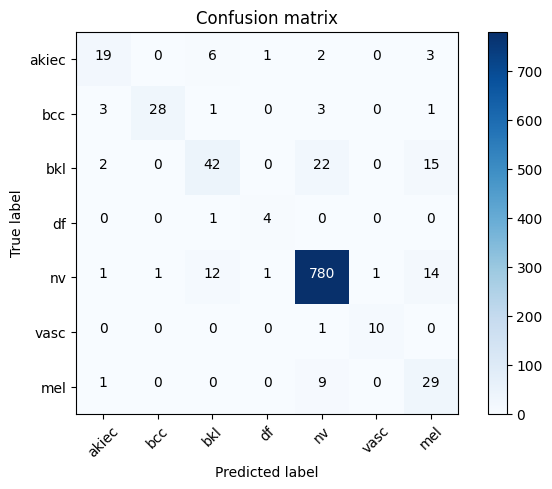

In [96]:
# Evaluate the model for male test data
male_accuracy = evaluate_gender(male_test_loader, "Male")



Female classification report:
              precision    recall  f1-score   support

       akiec       0.92      0.60      0.73        20
         bcc       0.84      0.88      0.86        24
         bkl       0.77      0.63      0.69        65
          df       1.00      0.71      0.83         7
          nv       0.96      0.97      0.96       726
        vasc       1.00      0.91      0.95        11
         mel       0.51      0.62      0.56        34

    accuracy                           0.92       887
   macro avg       0.86      0.76      0.80       887
weighted avg       0.92      0.92      0.92       887



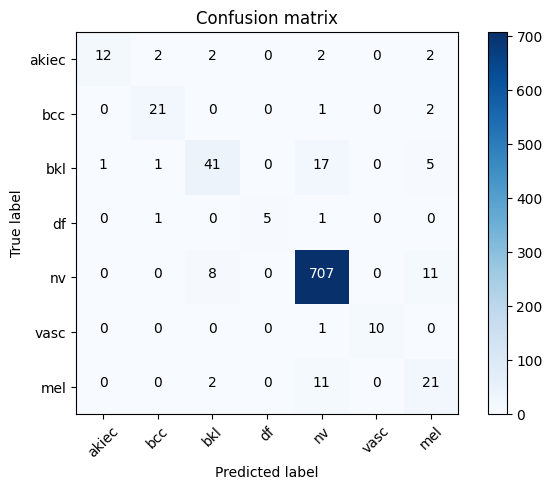

In [97]:
# Evaluate the model for female test data
female_accuracy = evaluate_gender(female_test_loader, "Female")


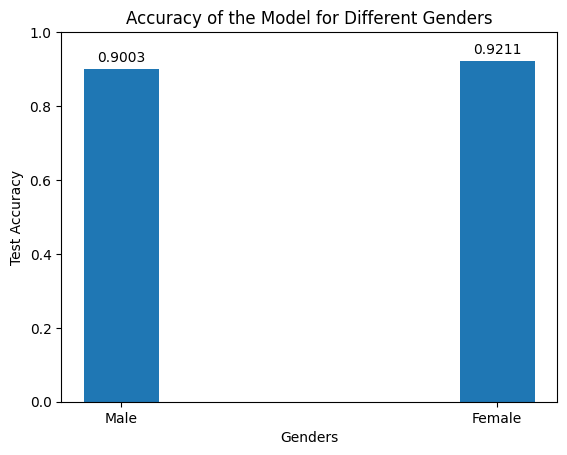

In [98]:
# Plot the bar chart with the accuracy values for each gender
genders = ["Male", "Female"]
accuracies = [male_accuracy, female_accuracy]

fig, ax = plt.subplots()
bars = ax.bar(genders, accuracies, width=0.2)  # Set the bar width here


plt.xlabel("Genders")
plt.ylabel("Test Accuracy")
plt.title("Accuracy of the Model for Different Genders")
plt.ylim(0, 1)

# Function to add the accuracy values on top of the bars
def add_values_on_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values_on_bars(bars)
plt.show()


### 3. Age

In [91]:
df_test['age'].value_counts()

45.0    311
50.0    276
55.0    234
40.0    218
60.0    164
35.0    148
65.0    114
70.0    110
75.0     94
30.0     79
80.0     65
25.0     35
20.0     20
85.0     17
5.0       9
15.0      3
10.0      2
Name: age, dtype: int64

In [92]:
# Filter the test dataset based on age groups
below_20_df = df_test[df_test['age'] <= 20].reset_index(drop=True)
between_20_40_df = df_test[(df_test['age'] > 20) & (df_test['age'] <= 40)].reset_index(drop=True)
between_40_60_df = df_test[(df_test['age'] > 40) & (df_test['age'] <= 60)].reset_index(drop=True)
above_60_df = df_test[df_test['age'] > 60].reset_index(drop=True)


In [93]:

# Create test DataLoaders for each age group
test_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

below_20_test_set = HAM10000(below_20_df, transform=test_transform)
below_20_test_loader = DataLoader(below_20_test_set, batch_size=32, shuffle=False, num_workers=4)

between_20_40_test_set = HAM10000(between_20_40_df, transform=test_transform)
between_20_40_test_loader = DataLoader(between_20_40_test_set, batch_size=32, shuffle=False, num_workers=4)

between_40_60_test_set = HAM10000(between_40_60_df, transform=test_transform)
between_40_60_test_loader = DataLoader(between_40_60_test_set, batch_size=32, shuffle=False, num_workers=4)

above_60_test_set = HAM10000(above_60_df, transform=test_transform)
above_60_test_loader = DataLoader(above_60_test_set, batch_size=32, shuffle=False, num_workers=4)


In [94]:
df_train.tail()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates,train_or_val,age_group
30842,31117,HAM_0001953,ISIC_0025611,mel,histo,65.0,male,back,dataset/HAM10000_images_part_1/ISIC_0025611.jpg,dermatofibroma,6,duplicated,train,3
30843,31118,HAM_0002552,ISIC_0032985,mel,histo,25.0,male,upper extremity,dataset/HAM10000_images_part_2/ISIC_0032985.jpg,dermatofibroma,6,duplicated,train,1
30844,31119,HAM_0002552,ISIC_0032936,mel,histo,25.0,male,upper extremity,dataset/HAM10000_images_part_2/ISIC_0032936.jpg,dermatofibroma,6,duplicated,train,1
30845,31120,HAM_0002552,ISIC_0033232,mel,histo,25.0,male,upper extremity,dataset/HAM10000_images_part_2/ISIC_0033232.jpg,dermatofibroma,6,duplicated,train,1
30846,31121,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back,dataset/HAM10000_images_part_2/ISIC_0032258.jpg,dermatofibroma,6,duplicated,train,3


In [95]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


def evaluate_age_group(age_group_test_loader, age_group_name):
    model.eval()
    y_label = []
    y_predict = []
    with torch.no_grad():
        for i, data in enumerate(age_group_test_loader):
            images, labels, _ = data  # add "_" to unpack the age_groups
            N = images.size(0)
            images = Variable(images).to(device)
            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]
            y_label.extend(labels.cpu().numpy())
            y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

    # Compute the confusion matrix
    confusion_mtx = confusion_matrix(y_label, y_predict)
    
    # Find unique labels in y_label and create a new target_names list
    unique_labels = np.unique(y_label)
    new_target_names = [plot_labels[i] for i in unique_labels]

    # Plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, new_target_names)

    # Print classification report with zero_division parameter set to 1
    age_group_report = classification_report(y_label, y_predict, labels=unique_labels, target_names=new_target_names, zero_division=1)
    print(f"{age_group_name} classification report:")
    print(age_group_report)
    
    # Return the accuracy value
    return accuracy_score(y_label, y_predict)


Below 20 classification report:
              precision    recall  f1-score   support

         bcc       1.00      1.00      1.00         1
         bkl       1.00      0.00      0.00         1
          nv       0.87      0.90      0.88        29
         mel       0.00      0.00      0.00         3

    accuracy                           0.79        34
   macro avg       0.72      0.47      0.47        34
weighted avg       0.80      0.79      0.78        34



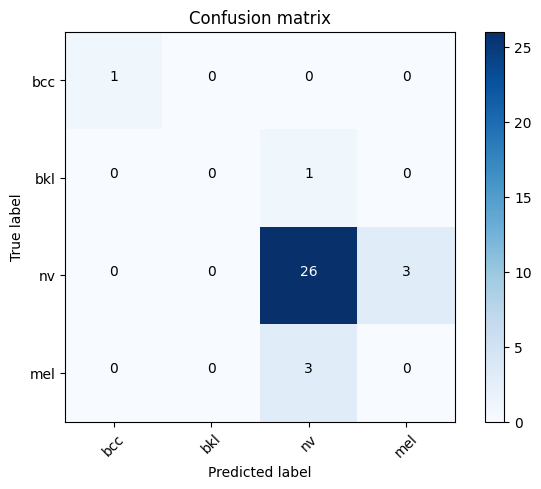

In [106]:
# Call the function for each age group and store the accuracy values
below_20_accuracy = evaluate_age_group(below_20_test_loader, "Below 20")


Between 20 and 40 classification report:
              precision    recall  f1-score   support

       akiec       0.33      1.00      0.50         2
         bcc       0.25      0.50      0.33         2
         bkl       0.22      0.89      0.36         9
          df       1.00      1.00      1.00         2
          nv       0.99      0.91      0.95       456
        vasc       0.80      1.00      0.89         4
         mel       0.00      0.00      0.00         5

    accuracy                           0.90       480
   macro avg       0.51      0.76      0.58       480
weighted avg       0.96      0.90      0.92       480



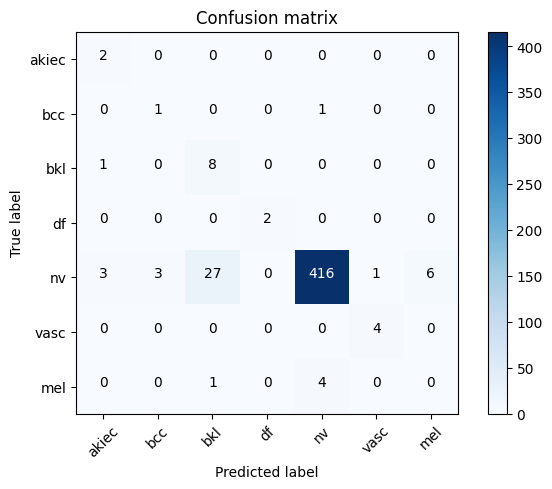

In [97]:
between_20_40_accuracy = evaluate_age_group(between_20_40_test_loader, "Between 20 and 40")


Between 40 and 60 classification report:
              precision    recall  f1-score   support

       akiec       0.88      0.62      0.73        24
         bcc       0.84      0.89      0.86        18
         bkl       0.74      0.59      0.66        54
          df       1.00      0.62      0.77         8
          nv       0.97      0.98      0.98       840
        vasc       1.00      1.00      1.00        15
         mel       0.50      0.69      0.58        26

    accuracy                           0.94       985
   macro avg       0.85      0.77      0.80       985
weighted avg       0.94      0.94      0.94       985



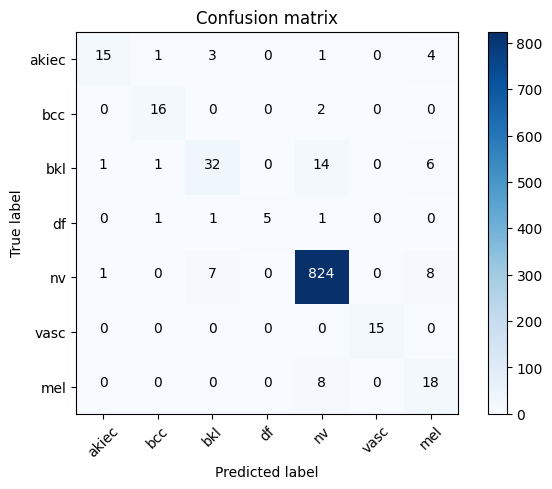

In [109]:
between_40_60_accuracy = evaluate_age_group(between_40_60_test_loader, "Between 40 and 60")



Above 60 classification report:
              precision    recall  f1-score   support

       akiec       0.70      0.56      0.62        25
         bcc       0.97      0.79      0.87        39
         bkl       0.81      0.54      0.65        82
          df       0.67      1.00      0.80         2
          nv       0.85      0.96      0.90       210
        vasc       1.00      0.67      0.80         3
         mel       0.60      0.79      0.68        39

    accuracy                           0.81       400
   macro avg       0.80      0.76      0.76       400
weighted avg       0.82      0.81      0.81       400



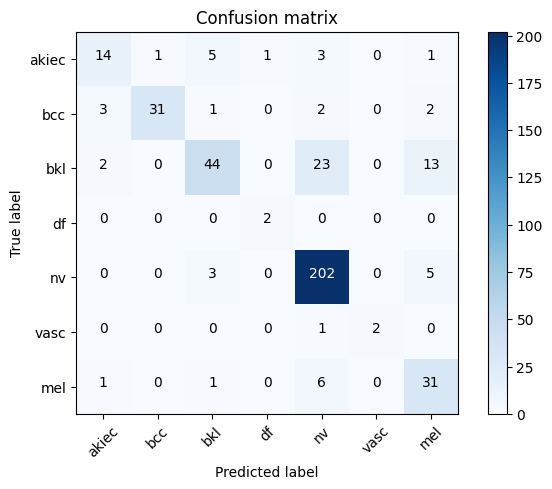

In [110]:
above_60_accuracy = evaluate_age_group(above_60_test_loader, "Above 60")


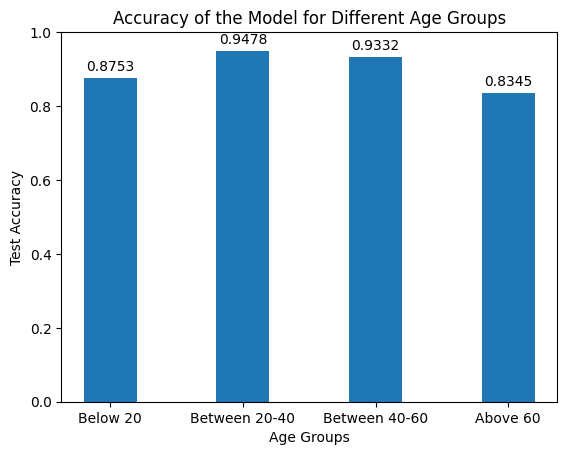

In [56]:

# Plot the bar chart with the accuracy values for each age group
age_groups = ["Below 20", "Between 20-40", "Between 40-60", "Above 60"]
accuracies = [below_20_accuracy, between_20_40_accuracy, between_40_60_accuracy, above_60_accuracy]

fig, ax = plt.subplots()
bars = ax.bar(age_groups, accuracies, width=0.4)

plt.xlabel("Age Groups")
plt.ylabel("Test Accuracy")
plt.title("Accuracy of the Model for Different Age Groups")
plt.ylim(0, 1)

# Function to add the accuracy values on top of the bars
def add_values_on_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values_on_bars(bars)
plt.show()
